## Installing libraries that are not in collab

In [272]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [273]:
ls

intents.json  output.png    test_data.csv
labels.json   sample_data/  train_data.csv


## Import Libraries
Importing the libraries that are required to perform operations on the dataset.

In [274]:
import json
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data preprocessing
Doing required processing of data.

In [275]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [276]:
df_train.head()

,text,intent
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [277]:
df_test.head()

,text,intent
0,Hi,greeting
1,How are you,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [278]:
len_labels = len(df_train.intent.unique())

In [279]:
df_train["intent"].value_counts()

course            34
fees              32
hostel            22
fest              21
scholarship       20
faculty           20
creator           18
hours             17
goodbye           17
location          16
name              15
number            15
document          13
salutation        12
library           12
admission         12
event             11
infrastructure    11
greeting          10
canteen           10
student portal     9
college intake     9
uniform            9
swear              9
placement          8
ragging            8
faculty portal     7
sports             7
transport          7
principal          7
syllabus           7
task               6
facilities         5
menu               5
csehod             4
hod                3
random             3
other              1
Name: intent, dtype: int64

In [280]:
df_test["intent"].value_counts()

course            34
fees              32
hostel            22
fest              21
scholarship       20
faculty           20
creator           18
hours             17
goodbye           17
location          16
name              15
number            15
document          13
salutation        12
library           12
admission         12
event             11
infrastructure    11
greeting          10
canteen           10
student portal     9
college intake     9
uniform            9
swear              9
placement          8
ragging            8
faculty portal     7
sports             7
transport          7
principal          7
syllabus           7
task               6
facilities         5
menu               5
csehod             4
hod                3
random             3
other              1
Name: intent, dtype: int64

In [281]:
# Converting the labels into encodings
le = LabelEncoder()
df_test['intent'] = le.fit_transform(df_test['intent'])
df_train['intent'] = le.fit_transform(df_train['intent'])

In [282]:
# check class distribution
df_train['intent'].value_counts(normalize = True)

3     0.075221
11    0.070796
16    0.048673
12    0.046460
30    0.044248
9     0.044248
4     0.039823
17    0.037611
13    0.037611
20    0.035398
22    0.033186
23    0.033186
6     0.028761
29    0.026549
19    0.026549
0     0.026549
7     0.024336
18    0.024336
14    0.022124
1     0.022124
32    0.019912
2     0.019912
37    0.019912
33    0.019912
25    0.017699
27    0.017699
10    0.015487
31    0.015487
36    0.015487
26    0.015487
34    0.015487
35    0.013274
8     0.011062
21    0.011062
5     0.008850
15    0.006637
28    0.006637
24    0.002212
Name: intent, dtype: float64

In [283]:
# check class distribution
df_test['intent'].value_counts(normalize = True)

3     0.075221
11    0.070796
16    0.048673
12    0.046460
30    0.044248
9     0.044248
4     0.039823
17    0.037611
13    0.037611
20    0.035398
22    0.033186
23    0.033186
6     0.028761
29    0.026549
19    0.026549
0     0.026549
7     0.024336
18    0.024336
14    0.022124
1     0.022124
32    0.019912
2     0.019912
37    0.019912
33    0.019912
25    0.017699
27    0.017699
10    0.015487
31    0.015487
36    0.015487
26    0.015487
34    0.015487
35    0.013274
8     0.011062
21    0.011062
5     0.008850
15    0.006637
28    0.006637
24    0.002212
Name: intent, dtype: float64

In [284]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df_train["text"], df_train["intent"]
test_text, test_labels = df_test["text"], df_test["intent"]


### Load Tokenizer

In [285]:
def load_tokenizer(model="bert"):
  tokenizer = None
  if model == "bert":
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
  if model == "roberta":
    # Load the Roberta tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
  if model == "distilbert":
    # Load the DistilBert tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  return tokenizer

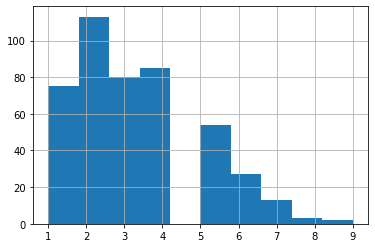

In [286]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

# Based on the histogram we are selecting the max len as 9
max_seq_len = 9

In [287]:
def get_tokenized_data(model="bert"):
  tokenizer = load_tokenizer(model=model)
  # tokenize and encode sequences in the training set
  tokens_train = tokenizer(
      train_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
                    )
  # tokenize and encode sequences in the testing set
  tokens_test = tokenizer(
      test_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
  )
  return tokens_train, tokens_test

In [288]:
tokens_train, tokens_test = get_tokenized_data()

In [289]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [290]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Setting Up models parameters

In [351]:
# Define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set and test set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Building our Lucy Model
To build lucy we are going to use pretrained Model and our own model.

### 1) Lucy layer

In [292]:
class Lucy(nn.Module):
  def __init__(self, pretrained_model):      
       super(Lucy, self).__init__()       
       self.pretrained_model = pretrained_model 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()     

       # dense layer       
       self.fc1 = nn.Linear(768,512)       
       self.fc2 = nn.Linear(512,256)       
       self.fc3 = nn.Linear(256,len_labels)    

       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)      
      
  #define the forward pass
  def forward(self, sent_id, mask):      
      #pass the inputs to the model  
      cls_hs = self.pretrained_model(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)      

      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)     
      return x

### 2) Pretrained layer + Lucy layer

In [293]:
def lucy_model(device,model="bert"):
  pretrained_model = None
  if model == "bert":
    # Import BERT-base pretrained model
    pretrained_model = AutoModel.from_pretrained("bert-base-uncased")

  if model == "roberta":
    # Import Roberta pretrained model
    pretrained_model = RobertaModel.from_pretrained("roberta-base")

  if model == "distilbert":
    # Import the DistilBert pretrained model
    pretrained_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

  # freeze all the parameters. This will prevent updating of model weights during fine-tuning.
  for param in pretrained_model.parameters():
        param.requires_grad = False

  lucy = Lucy(pretrained_model)

  # push the model to GPU or CPU
  lucy = lucy.to(device)

  return lucy

#### i) BERT

In [294]:
bert_model = lucy_model(device)
summary(bert_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

#### ii) Roberta

In [295]:
roberta_model = lucy_model(device, model="roberta")
summary(roberta_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                       Param #
Lucy                                                         --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (38,603,520)
│    │    └─Embedding: 3-2                                   (394,752)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                           

#### iii) DistilBert 

In [296]:
distilbert_model = lucy_model(device, model="distilbert")
summary(distilbert_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           9,766
├─LogSoftmax: 1-7                                       --
Total 

In [297]:
# define the optimizer for BERT, Roberta, DistilBERT
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr = 1e-3)
roberta_optimizer = torch.optim.AdamW(roberta_model.parameters(), lr = 1e-3)
distilbert_optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr = 1e-3)

In [298]:
#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[ 0.99122807  1.18947368  1.32163743  0.3498452   0.66081871  2.97368421
  0.91497976  1.08133971  2.37894737  0.59473684  1.69924812  0.37171053
  0.56641604  0.6996904   1.18947368  3.96491228  0.54066986  0.6996904
  1.08133971  0.99122807  0.74342105  2.37894737  0.79298246  0.79298246
 11.89473684  1.48684211  1.69924812  1.48684211  3.96491228  0.99122807
  0.59473684  1.69924812  1.32163743  1.32163743  1.69924812  1.98245614
  1.69924812  1.32163743]


In [299]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [300]:
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [301]:
# empty lists to store training  loss of each epoch
train_losses=[]

# empty lists to store training  accuracy of each epoch
train_accuracies=[]

# number of training epochs
epochs = 50

In [302]:
# function to train the model
def train(dataloader, model, optimizer):
  
  model.train()
  total_loss = 0
  total_correct = 0
  
  # empty list to save model predictions
  total_preds=[]

   # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 15 batches.
    if step % 50 == 0 and not step == 0:
      print('Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # get model accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))
    
    total_correct += (p == labels.detach().cpu()).float().sum()


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clear calculated gradients
    optimizer.zero_grad()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  
  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)
 
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
  return avg_loss, avg_accuracy, total_preds
  
 

In [303]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_accuracy ,_ = train(train_dataloader, bert_model, bert_optimizer)
    
    # append training loss
    train_losses.append(train_loss)

    # appedn training accuracy
    train_accuracies.append(train_accuracy)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy * 100:.3f} %')


 Epoch 1 / 50

Training Loss: 3.671

Training Accuracy: 2.434 %

 Epoch 2 / 50

Training Loss: 3.542

Training Accuracy: 11.726 %

 Epoch 3 / 50

Training Loss: 3.312

Training Accuracy: 18.142 %

 Epoch 4 / 50

Training Loss: 3.034

Training Accuracy: 23.673 %

 Epoch 5 / 50

Training Loss: 2.742

Training Accuracy: 28.319 %

 Epoch 6 / 50

Training Loss: 2.478

Training Accuracy: 33.850 %

 Epoch 7 / 50

Training Loss: 2.203

Training Accuracy: 42.920 %

 Epoch 8 / 50

Training Loss: 1.983

Training Accuracy: 48.009 %

 Epoch 9 / 50

Training Loss: 1.801

Training Accuracy: 50.442 %

 Epoch 10 / 50

Training Loss: 1.593

Training Accuracy: 54.425 %

 Epoch 11 / 50

Training Loss: 1.578

Training Accuracy: 58.407 %

 Epoch 12 / 50

Training Loss: 1.355

Training Accuracy: 59.956 %

 Epoch 13 / 50

Training Loss: 1.208

Training Accuracy: 65.265 %

 Epoch 14 / 50

Training Loss: 1.136

Training Accuracy: 64.381 %

 Epoch 15 / 50

Training Loss: 0.968

Training Accuracy: 70.796 %

 Epo

## Analysis of Training

In [304]:
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)

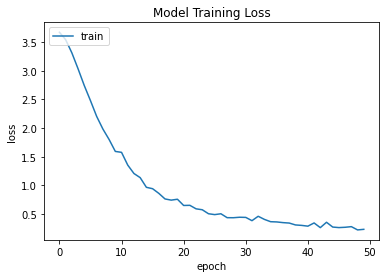

In [305]:
plt.plot(train_losses)
plt.title("Model Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.show()

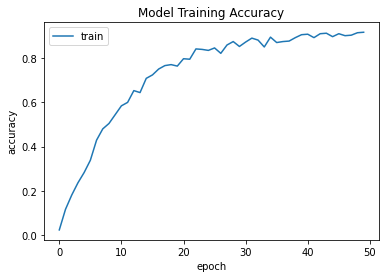

In [306]:
plt.plot(train_accuracies)
plt.title("Model Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.show()

## Saving the Lucy model

In [307]:
PATH = "lucy_bert.pth"
torch.save(bert_model.state_dict(), PATH)

## Testing the Lucy

In [308]:
# empty lists to store testing  loss of each epoch
test_losses=[]

# empty lists to store tesing  accuracy of each epoch
test_accuracies=[]

In [334]:
@torch.no_grad()
def test(dataloader, model):
  total_loss = 0
  total_correct = 0
  
  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print("Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader))")

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    
    # compute the accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))
    
    total_correct += (p == labels.detach().cpu()).float().sum()

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)

  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions

  return avg_loss,avg_accuracy, total_preds
  
 

In [335]:
test_loss, test_accuracy , test_y_preds = test(test_dataloader, bert_model)

print(f'\nTesting Loss: {test_loss:.3f}')
print(f'\nTesting Accuracy: {test_accuracy * 100:.3f} %')


Testing Loss: 0.047

Testing Accuracy: 99.115 %


In [341]:
test_y_preds = np.argmax(torch.tensor(test_y_preds), axis=-1)

In [342]:
classes = le.classes_.tolist()

In [343]:
test_y_true = []
for batch in test_dataloader:
   _, _, labels = batch
   a = torch.Tensor.tolist(labels)
   for i in a:
     test_y_true.append(i)
  

In [344]:
test_y_true = le.inverse_transform(test_y_true)

In [345]:
test_y_preds = le.inverse_transform(test_y_preds)

In [353]:
# Classification report
classification_report(test_y_true, test_y_preds)

'                precision    recall  f1-score   support\n\n     admission       1.00      1.00      1.00        12\n       canteen       0.91      1.00      0.95        10\ncollege intake       1.00      1.00      1.00         9\n        course       1.00      0.97      0.99        34\n       creator       1.00      1.00      1.00        18\n        csehod       1.00      1.00      1.00         4\n      document       1.00      1.00      1.00        13\n         event       1.00      1.00      1.00        11\n    facilities       1.00      1.00      1.00         5\n       faculty       1.00      1.00      1.00        20\nfaculty portal       1.00      1.00      1.00         7\n          fees       1.00      1.00      1.00        32\n          fest       1.00      1.00      1.00        21\n       goodbye       1.00      1.00      1.00        17\n      greeting       1.00      1.00      1.00        10\n           hod       1.00      1.00      1.00         3\n        hostel       1.00   

In [349]:
# Build confusion matrix
cf_matrix = confusion_matrix(test_y_true, test_y_preds)

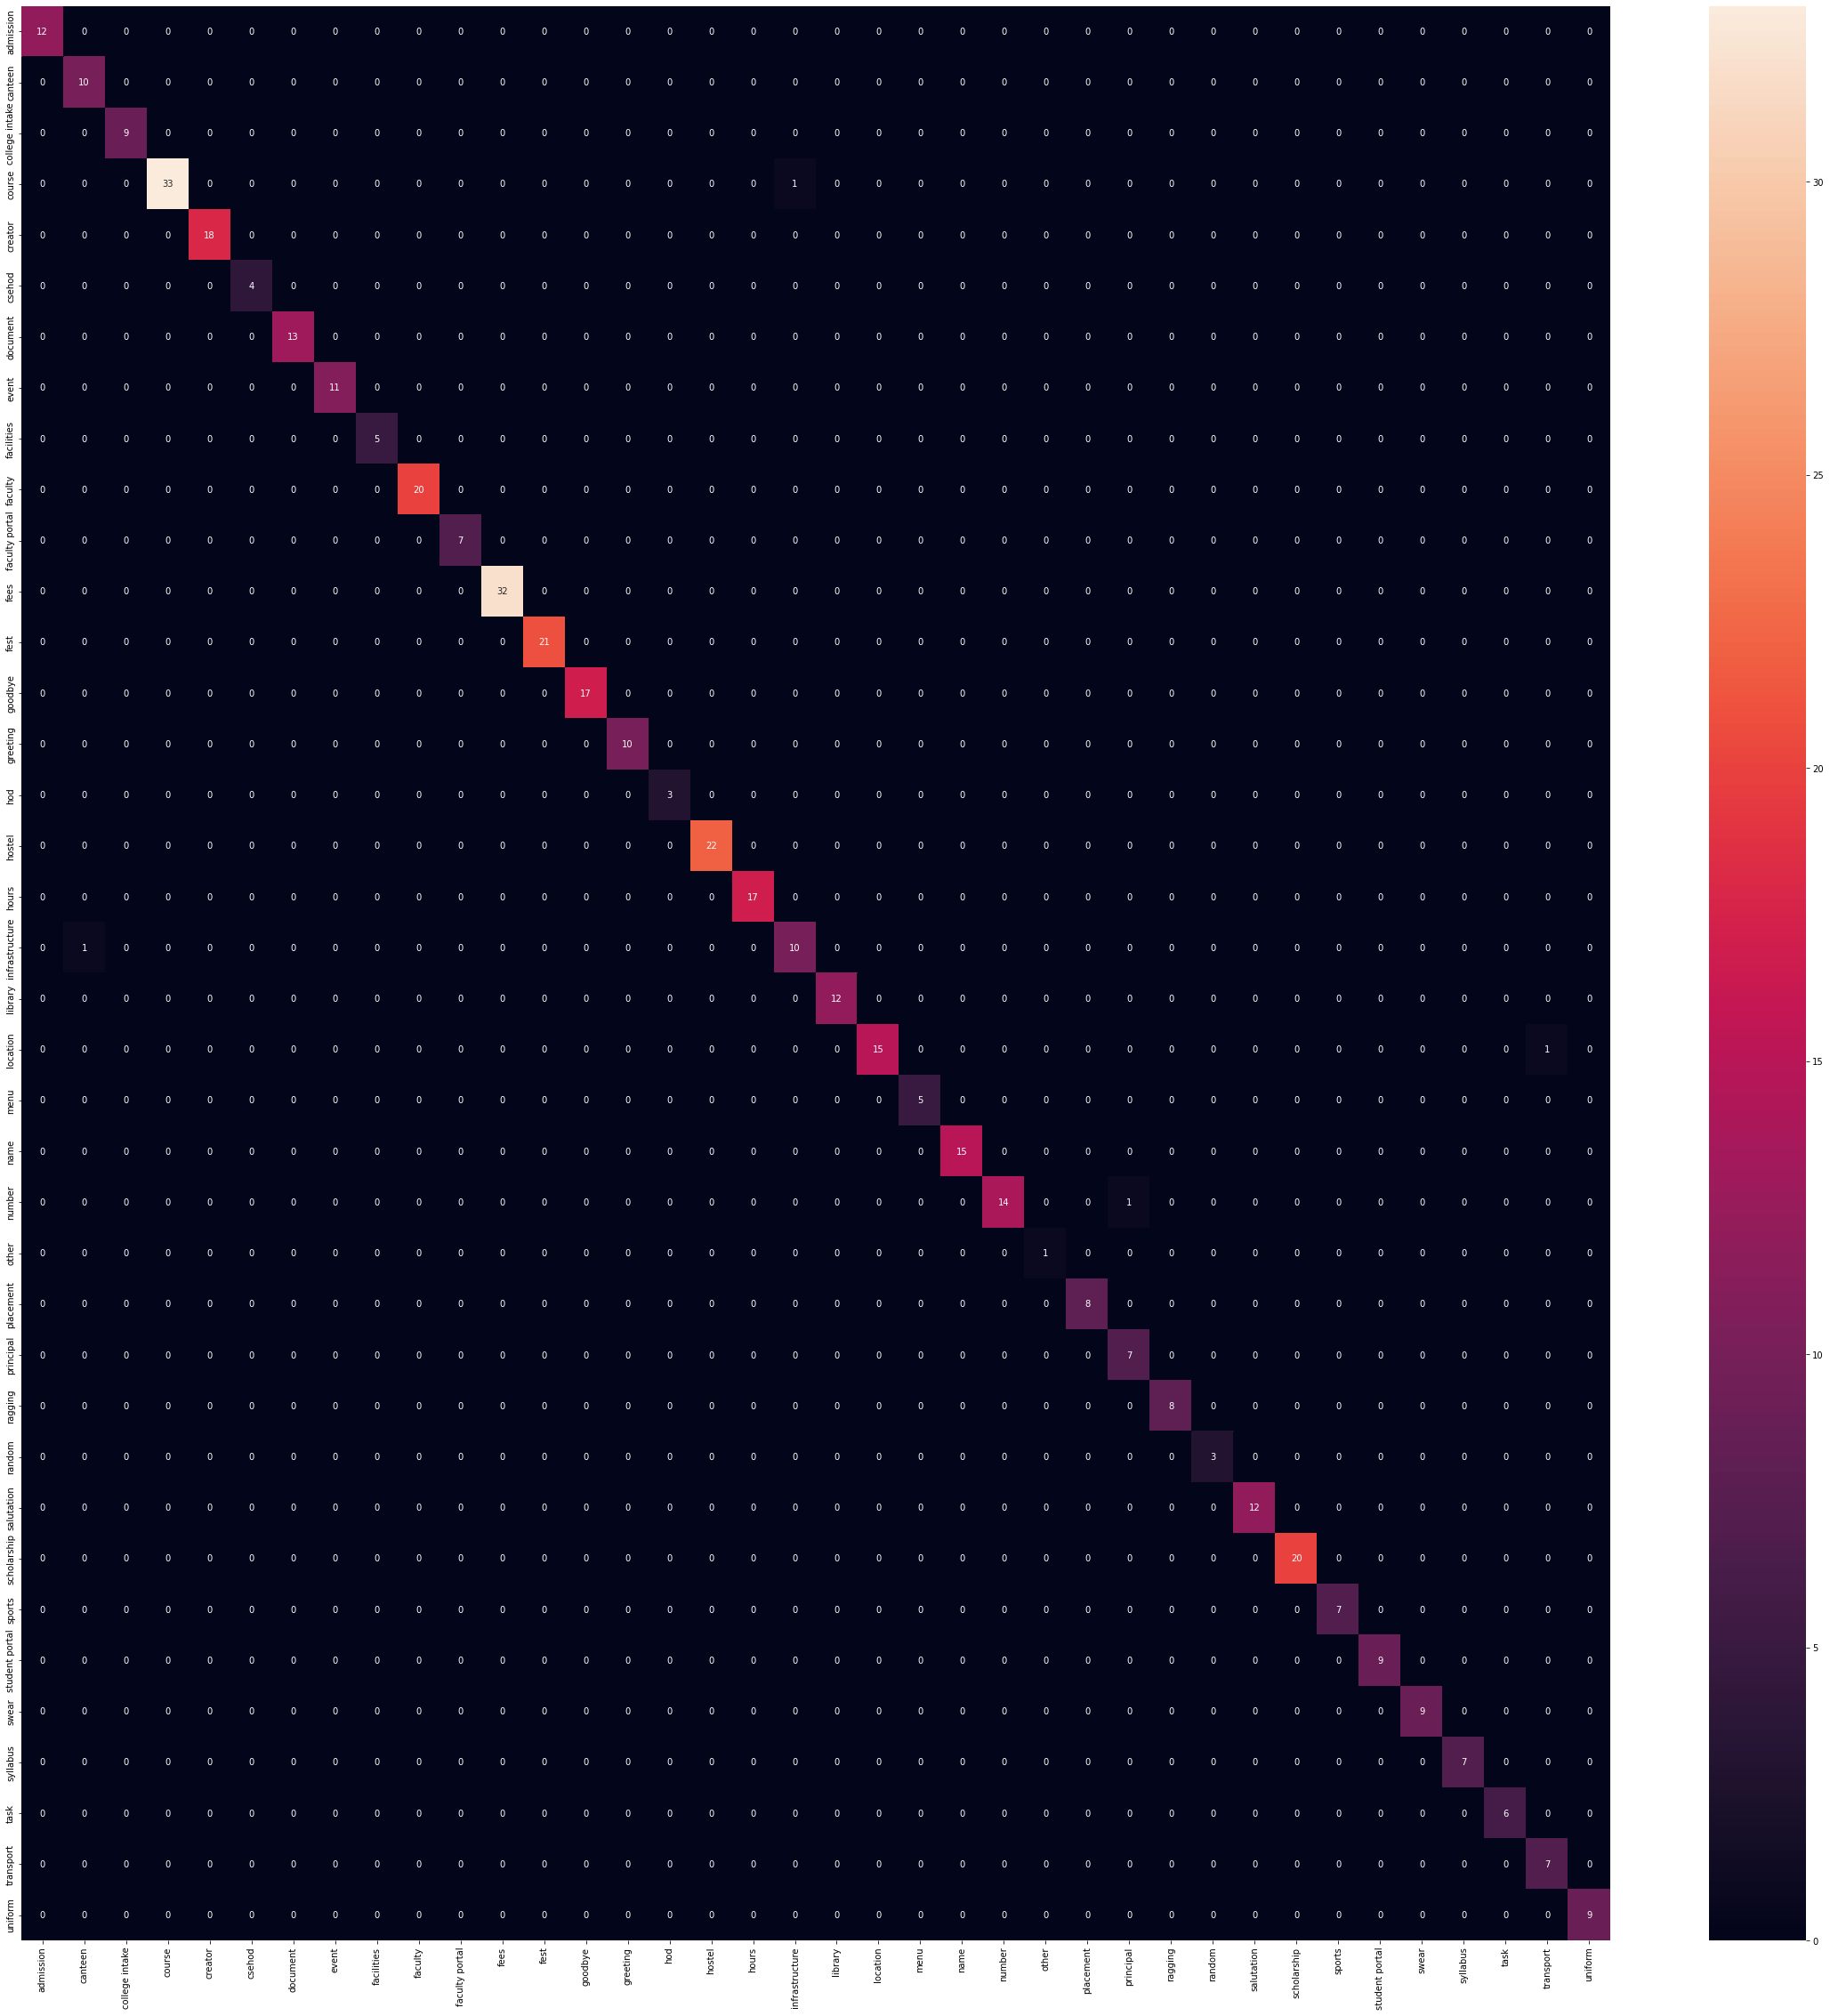

In [350]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (40,40))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

## Inference

In [269]:
def get_prediction(str, model, model_type):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 model.eval()
 tokenizer = load_tokenizer(model=model_type)
 
 tokens_test_data = tokenizer(
                  test_text,
                  max_length = max_seq_len,
                  padding="max_length",
                  truncation=True,
                  return_token_type_ids=False
                ) 
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
   
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print("Intent Identified: ", le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]


In [331]:
def get_response(intents_data, message): 
  intent = get_prediction(message, bert_model, "bert")
  for i in intents_data['intents']: 
     if i["tag"] == intent:
       result = random.choice(i["responses"])
       break
  print(f"Response : {result}")
  return "Intent: "+ intent + "\n" + "Response: " + result

In [332]:
f = open('intents.json')
data = json.load(f)


get_response(data, "Where is Nec?")

Intent Identified:  location
Response : Changunarayan, Bhaktapur, Nepal. For more details visit 


'Intent: location\nResponse: Changunarayan, Bhaktapur, Nepal. For more details visit '

In [158]:
import json

classes = le.classes_.tolist()
filename = 'labels.json'
with open(filename, 'w') as file_object:  
  json.dump(classes, file_object)